In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add code directory to path
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), 'code'))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from clustering import cluster_embeddings, cluster_sequences, get_designed_indices, plot_cluster_coverage
from config import load_config

In [5]:
config = load_config()
embeddings = np.load(config["embeddings_path"])
sequences_df = pd.read_csv(config["dataset_path"])
# use only the specific positions
sequences = sequences_df["full_seq"]
sequences = sequences.apply(lambda x: "".join([x[i - 1] for i in config["pos_to_use"]]))

Loaded configuration:
  root_path: /home/labs/fleishman/omripo/Projects/adaptive_learning
  data_dir_name: data
  pretraining_dir_name: pretraining
  bootstrap_dir_name: bootstrap
  results_dir_name: results
  enzyme: PTE
  substrate: p-nitrophenyl_acetate
  dataset_filename: llm_input_original_paper.csv
  tag: clustering_funclib_paper
  weights_filename: final_model.pt
  model_type: plm
  finetune: True
  opmode: mean
  train_type: msa_backbone
  nmuts_column: num_muts
  sequence_column_name: full_seq
  activity_column_name: inactive
  first_column_name: I106
  last_column_name: M317
  plm_name: esm2_t12_35M_UR50D
  ref_seq: DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALAEKAVRGLRRARAAGVRTIVDVSTFDIGRDVSLLAEVSRAADVHIVAATGLWFDPPLSMRLRSVEELTQFFLREIQYGIEDTGIRAGIIKVATTGKATPFQELVLKAAARASLATGVPVTTHTAASQRDGEQQAAIFESEGLSPSRVCIGHSDDTDDLSYLTALAARGYLIGLDHIPHSAIGLEDNASASALLGIRSWQTRALLIKALIDQGYMKQILVSNDWLFGFSSYVTNIMDVMDRVNPDGMAFIPLRVIPFLREKGVPQETLAGITVTNPARFLSPTLRAS
  bootstrap_indices_prefix: indice

In [ ]:
n_clusters = 20

In [ ]:
positive_idxs, negative_idxs = get_designed_indices(config["substrate_specific_dataset_path"], 
                                                    positive_threshold=15,
                                                    negative_threshold=0.5)

In [ ]:
cluster_labels, representative_indices = cluster_embeddings(
        embeddings,
        n_clusters=n_clusters,
        save_path=config["embeddings_clusters_path"],
)

In [ ]:
sequence_cluster_labels, seq_representative_indices = cluster_sequences(
    sequences, n_clusters=n_clusters, save_path=config["sequence_clusters_path"]
)

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()
reduced_embeddings = reducer.fit_transform(embeddings)
plt.figure(figsize=(6, 6))
# create scatter plot with binary color map and a legend
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=cluster_labels if cluster_labels is not None else "blue",
    cmap="Spectral",
    s=5,
)

# if positive_indices is not None and negative_indices is not None
# plot using the cluster colormap, but change shapes of designed points

design_title = ""

if positive_idxs is not None and negative_idxs is not None:
    plt.scatter(
        reduced_embeddings[negative_idxs, 0],
        reduced_embeddings[negative_idxs, 1],
        c="none",
        edgecolor="black",
        marker="X",
        s=50,
        label="Negative Design",
    )
    plt.scatter(
        reduced_embeddings[positive_idxs, 0],
        reduced_embeddings[positive_idxs, 1],
        c="none",
        edgecolor="red",
        marker="^",
        s=50,
        label="Positive Design",
    )
    plt.legend()
    design_title = f"\n+designs: {len(positive_idxs)}, -designs: {len(negative_idxs)}"


plt.title(f"UMAP projection of the LLM embeddings: \n {n_clusters} clusters, opmode={config['opmode']}, finetune={config['finetune']}{design_title}")
plt.show()

In [ ]:
n_clusters = len(np.unique(sequence_cluster_labels))
coverage_data = []
for cluster_id in range(n_clusters):
    cluster_seq_indices = np.where(sequence_cluster_labels == cluster_id)[0]

    n_positive = len(set(cluster_seq_indices) & set(positive_idxs))
    n_negative = len(set(cluster_seq_indices) & set(negative_idxs))
    n_total = n_positive + n_negative
    coverage_data.append(
        {
            "cluster_id": cluster_id,
            "n_total": n_total,
            "n_positive": n_positive,
            "n_negative": n_negative,
            "positive_fraction": n_positive / n_total if n_total > 0 else 0,
            "negative_fraction": n_negative / n_total if n_total > 0 else 0,
        }
    )
coverage_df = pd.DataFrame(coverage_data)

# plot bar chart of positive and negative fractions per cluster. Show the number of each type in the bars, and
# stack the bars on top of each other
plt.figure(figsize=(10, 6))
bar1 = plt.bar(
    coverage_df["cluster_id"], coverage_df["positive_fraction"], color="blue", label="Positive Designs"
)
bar2 = plt.bar(
    coverage_df["cluster_id"], coverage_df["negative_fraction"], bottom=coverage_df["positive_fraction"], color="black", label="Negative Designs"
)  
for i in range(len(coverage_df)):
    plt.text(
        coverage_df["cluster_id"][i],
        coverage_df["positive_fraction"][i] / 2,
        str(coverage_df["n_positive"][i]),
        ha="center",
        va="center",
        color="white",
    )
    plt.text(
        coverage_df["cluster_id"][i],
        coverage_df["positive_fraction"][i] + coverage_df["negative_fraction"][i] / 2,
        str(coverage_df["n_negative"][i]),
        ha="center",
        va="center",
        color="white",
    )
plt.xlabel("Cluster ID")
plt.ylabel("Fraction of Designed Sequences")
plt.legend()

plt.title("Coverage of Designed Sequences in Clusters")

In [ ]:
n_clusters = len(np.unique(cluster_labels))
coverage_data = []
for cluster_id in range(n_clusters):
    cluster_seq_indices = np.where(cluster_labels == cluster_id)[0]

    n_positive = len(set(cluster_seq_indices) & set(positive_idxs))
    n_negative = len(set(cluster_seq_indices) & set(negative_idxs))
    n_total = n_positive + n_negative
    coverage_data.append(
        {
            "cluster_id": cluster_id,
            "n_total": n_total,
            "n_positive": n_positive,
            "n_negative": n_negative,
            "positive_fraction": n_positive / n_total if n_total > 0 else 0,
            "negative_fraction": n_negative / n_total if n_total > 0 else 0,
        }
    )
coverage_df = pd.DataFrame(coverage_data)

# plot bar chart of positive and negative fractions per cluster. Show the number of each type in the bars, and
# stack the bars on top of each other
plt.figure(figsize=(10, 6))
bar1 = plt.bar(
    coverage_df["cluster_id"], coverage_df["positive_fraction"], color="blue", label="Positive Designs"
)
bar2 = plt.bar(
    coverage_df["cluster_id"], coverage_df["negative_fraction"], bottom=coverage_df["positive_fraction"], color="black", label="Negative Designs"
)  
for i in range(len(coverage_df)):
    plt.text(
        coverage_df["cluster_id"][i],
        coverage_df["positive_fraction"][i] / 2,
        str(coverage_df["n_positive"][i]),
        ha="center",
        va="center",
        color="white",
    )
    plt.text(
        coverage_df["cluster_id"][i],
        coverage_df["positive_fraction"][i] + coverage_df["negative_fraction"][i] / 2,
        str(coverage_df["n_negative"][i]),
        ha="center",
        va="center",
        color="white",
    )
plt.xlabel("Cluster ID")
plt.ylabel("Fraction of Designed Sequences")
plt.legend()

plt.title("Coverage of Designed Sequences in Clusters")

In [ ]:
# get designed sequences in cluster 11
cluster_id = 2
cluster_seq_indices = np.where(cluster_labels == cluster_id)[0]
positive_designed_in_cluster = set(cluster_seq_indices) & set(positive_idxs)
negative_designed_in_cluster = set(cluster_seq_indices) & set(negative_idxs)

sequences_df.iloc[list(positive_designed_in_cluster) + list(negative_designed_in_cluster)]

In [ ]:
import logomaker as lm

In [ ]:
n_clusters = len(np.unique(cluster_labels))
# create one figure with n_clusters subplots. Each row should have 4 subplots
n_cols = 4
n_rows = int(np.ceil(n_clusters / n_cols))
plt.figure(figsize=(n_cols * 4, n_rows * 4))
for cluster_id in range(n_clusters):
    cluster_seqs = sequences[np.where(cluster_labels == cluster_id)[0]]
    # create a count matrix
    count_matrix = lm.alignment_to_matrix(sequences=cluster_seqs, to_type="counts")
    ax = plt.subplot(n_rows, n_cols, cluster_id + 1)
    # create a logo
    logo = lm.Logo(count_matrix, color_scheme="chemistry", ax=ax)
    logo.style_spines(visible=False)
    logo.style_spines(spines=["left", "bottom"], visible=True)
    logo.style_xticks(rotation=90, fmt="%d", anchor=0)
    plt.title(f"Cluster {cluster_id} (n={len(cluster_seqs)})")
plt.suptitle(f"Sequence Logos for {config["enzyme"]} Clusters", fontsize=16)
plt.show()

In [6]:
substrate_df = pd.read_csv(config["substrate_specific_dataset_path"])
substrate_df = substrate_df[substrate_df["design"] != -1]
fold_improvements = substrate_df["fold_improvement"]
log_fold_improvements = np.log10(fold_improvements + 1e-6)

designed_cluster_labels = cluster_labels[substrate_df.index]

# plot scatter plot of log fold improvements vs cluster id
plt.figure(figsize=(10, 6))
plt.scatter(
    designed_cluster_labels,
    log_fold_improvements,
    c="blue",
    s=5,
)


NameError: name 'cluster_labels' is not defined

In [100]:
hh_mean = torch.nn.functional.normalize(
                hh[:, torch.tensor(model.specific_pos), :], dim=1
            ).mean(dim=1)
hh_mean = hh_mean.cpu().detach().numpy()

In [ ]:
# find mean diff between hh_mean[test_indices] and X_test_emb
(hh_mean[train_indices] - X_train_emb).mean()

In [61]:
# take random sample of n embeddings
n = 20
random_indices = np.random.choice(embeddings.shape[0], size=n, replace=False)
(hh_mean[train_indices] - embeddings[random_indices]).mean()

np.float32(-4.553345e-05)

In [101]:
mlp_reg_emb_new = MLPRegressor(
    hidden_layer_sizes=(hidden_layer_size),
    activation="logistic",
    learning_rate="invscaling",
    random_state=42,
    verbose=False,
    max_iter=20000,
)
mlp_reg_emb_new.fit(hh_mean, y_train_new)

,loss,'squared_error'
,hidden_layer_sizes,16
,activation,'logistic'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'invscaling'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,20000
,shuffle,True


In [102]:
mlp_reg_emb_new.predict(embeddings[test_indices])

array([1.6617196, 1.6594929, 1.6622715, 1.6606845, 1.6615646, 1.6614814,
       1.661835 , 1.6612899, 1.6603556, 1.6607841, 1.6619506, 1.659388 ,
       1.6590595, 1.661985 , 1.6612654, 1.6638497, 1.660297 , 1.6619977,
       1.6627715, 1.6598672, 1.6596065, 1.660071 , 1.6600412, 1.6610806,
       1.6602741, 1.6609688, 1.6623397, 1.6624991, 1.659783 , 1.6602906],
      dtype=float32)

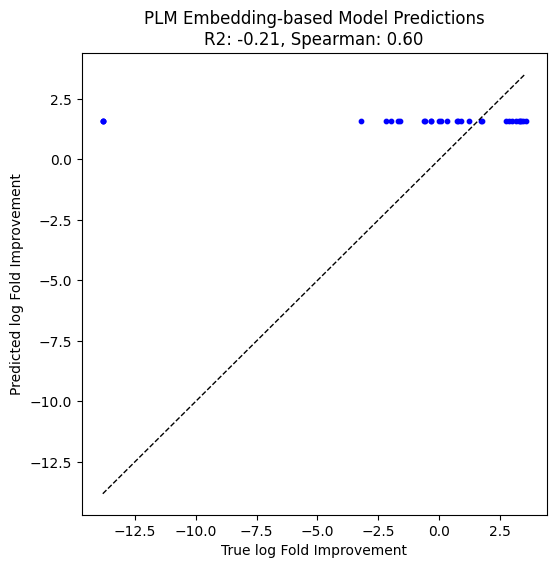

In [65]:

emb_predictions_new = mlp_reg_emb_new.predict(hh_mean[test_indices])
# plot scatter plot of true vs predicted for the new model
plt.figure(figsize=(6, 6))
plt.scatter(y_test, emb_predictions_new, c="blue", s=10)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=1)
plt.xlabel("True log Fold Improvement")
plt.ylabel("Predicted log Fold Improvement")
# add spearman and r2 to the title
emb_r2_new = r2_score(y_test, emb_predictions_new)
emb_spearman_new = spearmanr(y_test, emb_predictions_new).correlation
plt.title(f"PLM Embedding-based Model Predictions{f'\nR2: {emb_r2_new:.2f}, Spearman: {emb_spearman_new:.2f}'}")
plt.show()

In [68]:
train_emb_new = hh_mean[train_indices]